In [64]:
# Data & numeric processing
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# Machine learning: scaling, clustering, feature selection
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# Network construction & community detection
import networkx as nx
import community as community_louvain


In [66]:
# === STEP 1: Load Cleaned Data for Windermere North Basin ===

# === Load Cleaned Datasets and Filter Windermere North ===
nutrients_df = pd.read_csv("./Processed/Cleaned_Nutrients_Data.csv", parse_dates=["Date"])
hydro_df = pd.read_csv("./Processed/Cleaned_Merged_WaterMonitoring_Data.csv", parse_dates=["Date"])
phyto_df = pd.read_csv("./Processed/Cleaned_WindermereNorth_Plankton_Data.csv", parse_dates=["Date"])



In [68]:
# === Step 2A: Monthly Nutrients + Hydrology ===

# Filter for 'North' in lake name
nutrients_filtered = nutrients_df[nutrients_df["Name"].str.contains("North", case=False)].copy()

# Define variables
nutrient_vars = ["Nitrate", "Ammonium", "Phosphate"]
hydro_vars = ["Surface Oxygen", "Surface Temperature", "Secchi Depth"]

# Include date + selected variables
selected_nutrient_df = nutrients_filtered[["Date"] + nutrient_vars + hydro_vars].copy()

# ✅ Correct for day-first format
selected_nutrient_df["Date"] = pd.to_datetime(selected_nutrient_df["Date"], dayfirst=True)
selected_nutrient_df = selected_nutrient_df.set_index("Date")

# Resample to monthly means
monthly_nutrient_hydro = selected_nutrient_df.resample("ME").mean()

# === Step 2B: Monthly Phytoplankton ===

# Instead, we prepare an empty monthly_phyto DataFrame with same index as nutrient_hydro
monthly_phyto = pd.DataFrame(index=monthly_nutrient_hydro.index)


In [70]:
# === Step 3: Restrict Timeframe and Construct Final Forcing Matrix ===

# Define consistent long-term window
start_date = "1978-01-01"
end_date = "2005-12-31"

# Restrict nutrient + hydro to this range
monthly_nutrient_hydro = monthly_nutrient_hydro.loc[start_date:end_date]

# Preview shape and structure
print("✅ Forcing matrix shape:", monthly_nutrient_hydro.shape)
print("✅ Columns:", monthly_nutrient_hydro.columns.tolist())
print("✅ Date range:", monthly_nutrient_hydro.index.min(), "→", monthly_nutrient_hydro.index.max())


✅ Forcing matrix shape: (336, 6)
✅ Columns: ['Nitrate', 'Ammonium', 'Phosphate', 'Surface Oxygen', 'Surface Temperature', 'Secchi Depth']
✅ Date range: 1978-01-31 00:00:00 → 2005-12-31 00:00:00


✅ Best number of clusters based on silhouette score: k = 2


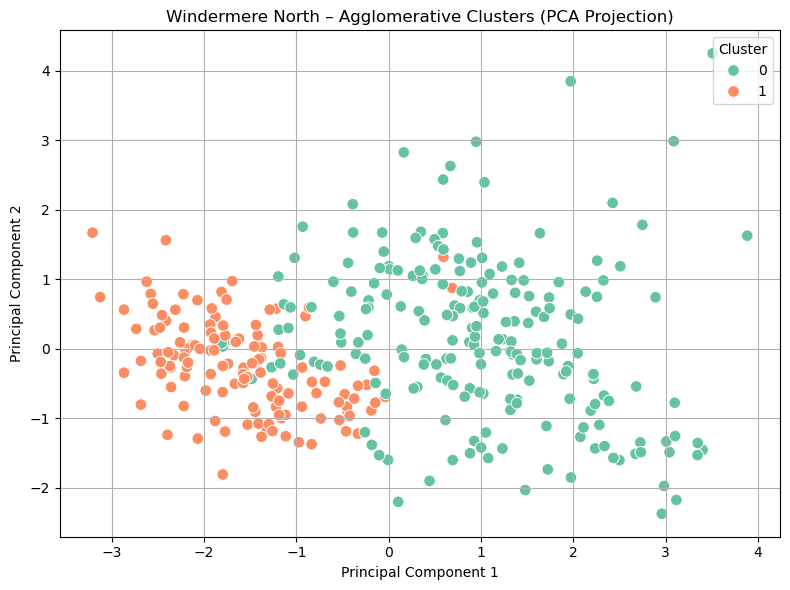

In [72]:
# === Step 4: Agglomerative Clustering with Silhouette Scores ===

# Standardize input
scaler = StandardScaler()
X_scaled = scaler.fit_transform(monthly_nutrient_hydro)

# Try cluster counts from 2 to 7 and track silhouette score
sil_scores = {}
for k in range(2, 8):
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X_scaled)
    if len(set(labels)) > 1:
        sil_scores[k] = silhouette_score(X_scaled, labels)

# Best number of clusters
best_k = max(sil_scores, key=sil_scores.get)
print(f"✅ Best number of clusters based on silhouette score: k = {best_k}")

# Final model
final_model = AgglomerativeClustering(n_clusters=best_k)
monthly_nutrient_hydro["Cluster"] = final_model.fit_predict(X_scaled)


# === Reduce dimensions for visualization ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA + cluster info to DataFrame
monthly_nutrient_hydro["PCA1"] = X_pca[:, 0]
monthly_nutrient_hydro["PCA2"] = X_pca[:, 1]

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=monthly_nutrient_hydro, x="PCA1", y="PCA2", hue="Cluster", palette="Set2", s=70)
plt.title("Windermere North – Agglomerative Clusters (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [74]:
# === Assign Descriptive Seasonal Labels to Clusters ===

# Manually define seasonal interpretations for each cluster ID
cluster_labels_map = {
    0: "Cool Season (Spring/Winter-like)",
    1: "Warm Season (Summer/Autumn-like)"
}

# Add readable labels to DataFrame
monthly_nutrient_hydro["Cluster_Label"] = monthly_nutrient_hydro["Cluster"].map(cluster_labels_map)


In [76]:
# === Step 7: Cosine Similarity Graph + Louvain Detection ===

# Step 1: Select input features (exclude cluster columns)
features_for_graph = monthly_nutrient_hydro.drop(columns=["Cluster", "Cluster_Label", "PCA1", "PCA2"])

# Step 2: Compute cosine similarity matrix
cos_sim = cosine_similarity(features_for_graph)
cos_sim[cos_sim < 0.80] = 0  # retain only strong similarities

# Step 3: Build graph
G = nx.from_numpy_array(cos_sim)

# Step 4: Label nodes by date (e.g., '1978-01')
monthly_nutrient_hydro["Label"] = monthly_nutrient_hydro.index.strftime("%Y-%m")
label_dict = dict(enumerate(monthly_nutrient_hydro["Label"]))
G = nx.relabel_nodes(G, label_dict)

# Step 5: Run Louvain detection
partition = community_louvain.best_partition(G)
monthly_nutrient_hydro["Louvain"] = monthly_nutrient_hydro["Label"].map(partition)

# Step 6: Print graph info
print("✅ Graph G:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")
print("✅ Louvain communities detected:", len(set(partition.values())))


✅ Graph G: 336 nodes, 53531 edges
✅ Louvain communities detected: 6


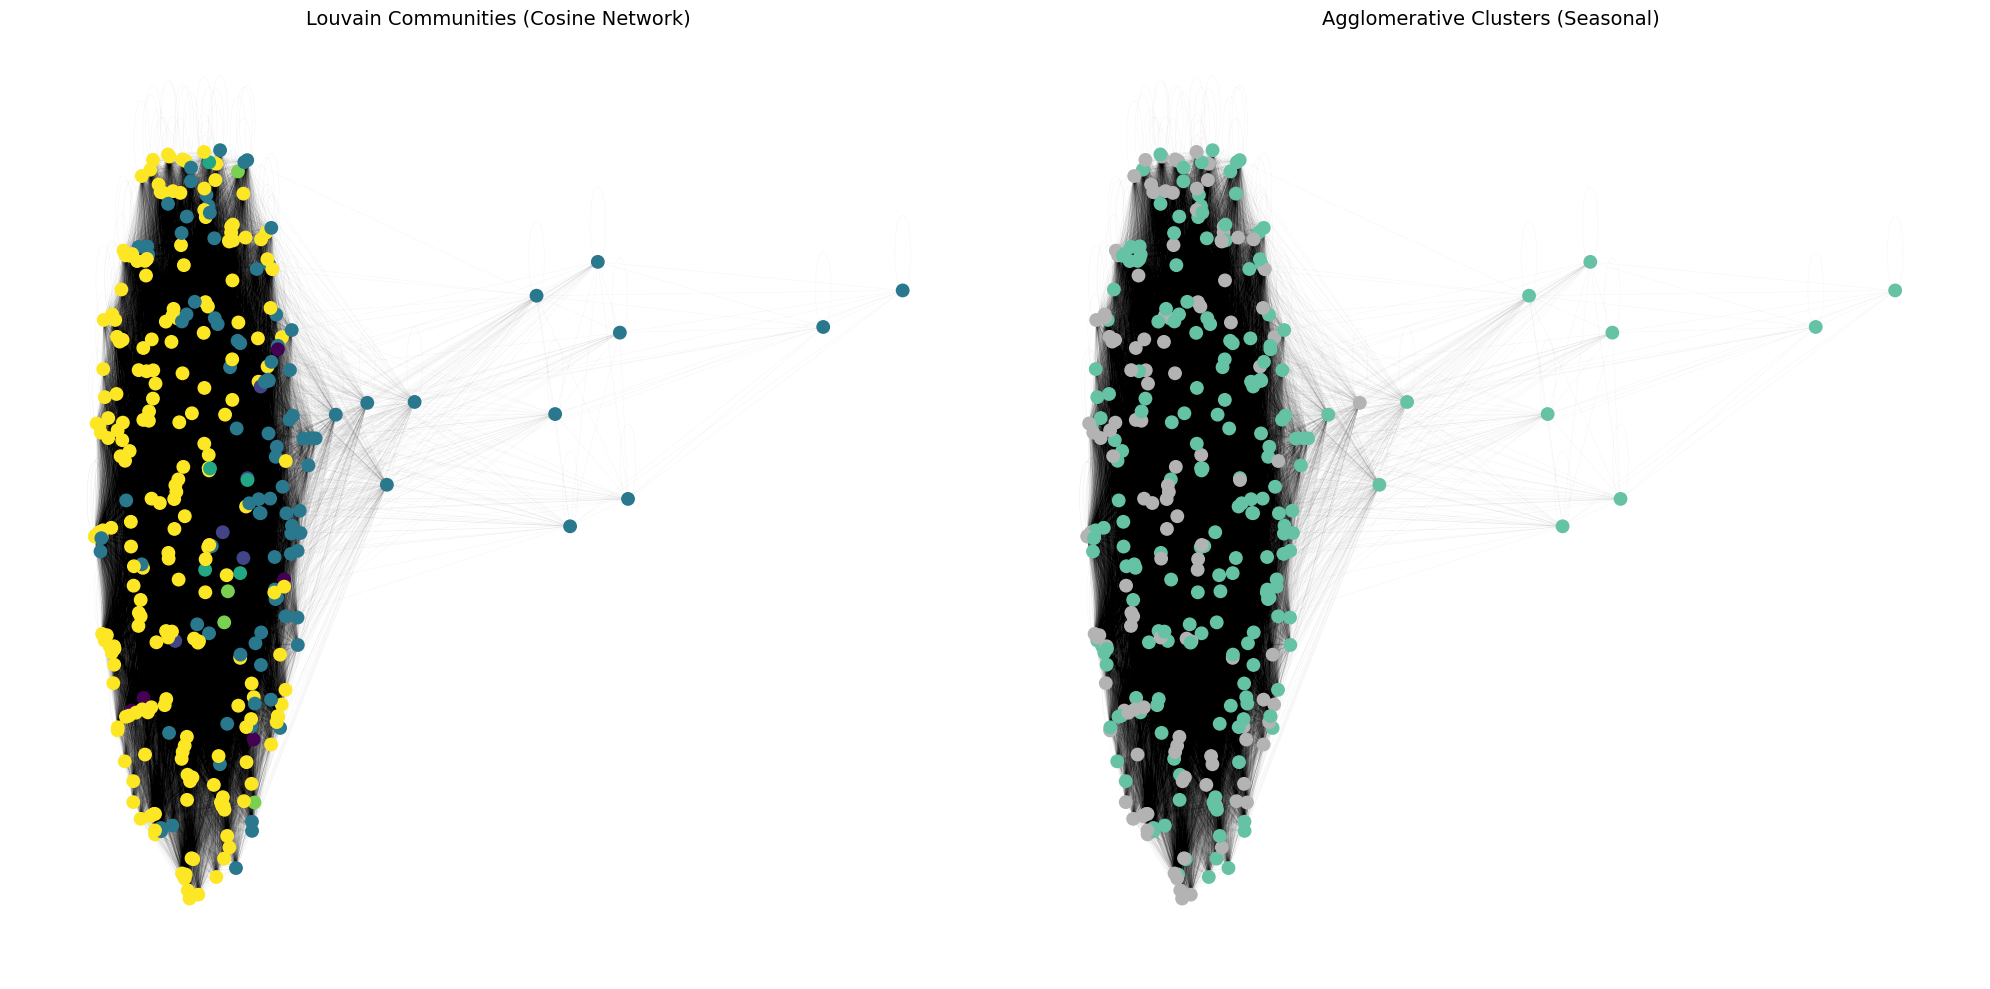

In [78]:
# === Step 8: Dual Panel — Louvain vs Agglomerative Clusters ===

# Setup layout
pos = nx.spring_layout(G, seed=42)
node_labels = list(G.nodes())

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# === Left Panel: Louvain Communities ===
louvain_colors = monthly_nutrient_hydro.set_index("Label").loc[node_labels, "Louvain"].astype("category").cat.codes

nx.draw_networkx_edges(G, pos, alpha=0.05, edge_color="black", width=0.3, ax=axes[0])
nx.draw_networkx_nodes(G, pos,
                       node_color=louvain_colors,
                       cmap=plt.cm.viridis,
                       node_size=80,
                       ax=axes[0])
axes[0].set_title("Louvain Communities (Cosine Network)", fontsize=14)
axes[0].axis("off")

# === Right Panel: Seasonal Clusters ===
season_colors = monthly_nutrient_hydro.set_index("Label").loc[node_labels, "Cluster_Label"].astype("category").cat.codes

nx.draw_networkx_edges(G, pos, alpha=0.05, edge_color="black", width=0.3, ax=axes[1])
nx.draw_networkx_nodes(G, pos,
                       node_color=season_colors,
                       cmap=plt.cm.Set2,
                       node_size=80,
                       ax=axes[1])
axes[1].set_title("Agglomerative Clusters (Seasonal)", fontsize=14)
axes[1].axis("off")

# Layout polish
plt.tight_layout()
plt.show()


In [80]:
# === Vertex Clustering Panels Setup ===

# Step 1: Ensure node labels match DataFrame index
node_labels = list(G.nodes())

# Step 2: Start with your existing nutrient + hydro monthly matrix
monthly_all = monthly_nutrient_hydro.copy()

# Step 3: Add cluster labels if not already added
# Replace `cluster_labels` with your actual array from PAM or Agglomerative
# Example:
# monthly_all["Cluster_Label"] = cluster_model.labels_

# Step 4: Check if cluster labels are present
assert "Cluster_Label" in monthly_all.columns, "❌ Cluster_Label column missing from monthly_all"

# Step 5: Optional — ensure index type matches node_labels (string vs datetime)
if isinstance(node_labels[0], str) and isinstance(monthly_all.index[0], pd.Timestamp):
    monthly_all.index = monthly_all.index.strftime("%Y-%m")  # or another date format matching G
elif isinstance(node_labels[0], pd.Timestamp) and isinstance(monthly_all.index[0], str):
    monthly_all.index = pd.to_datetime(monthly_all.index)

# Step 6: Filter to only include nodes present in G
monthly_all = monthly_all.loc[monthly_all.index.intersection(node_labels)]



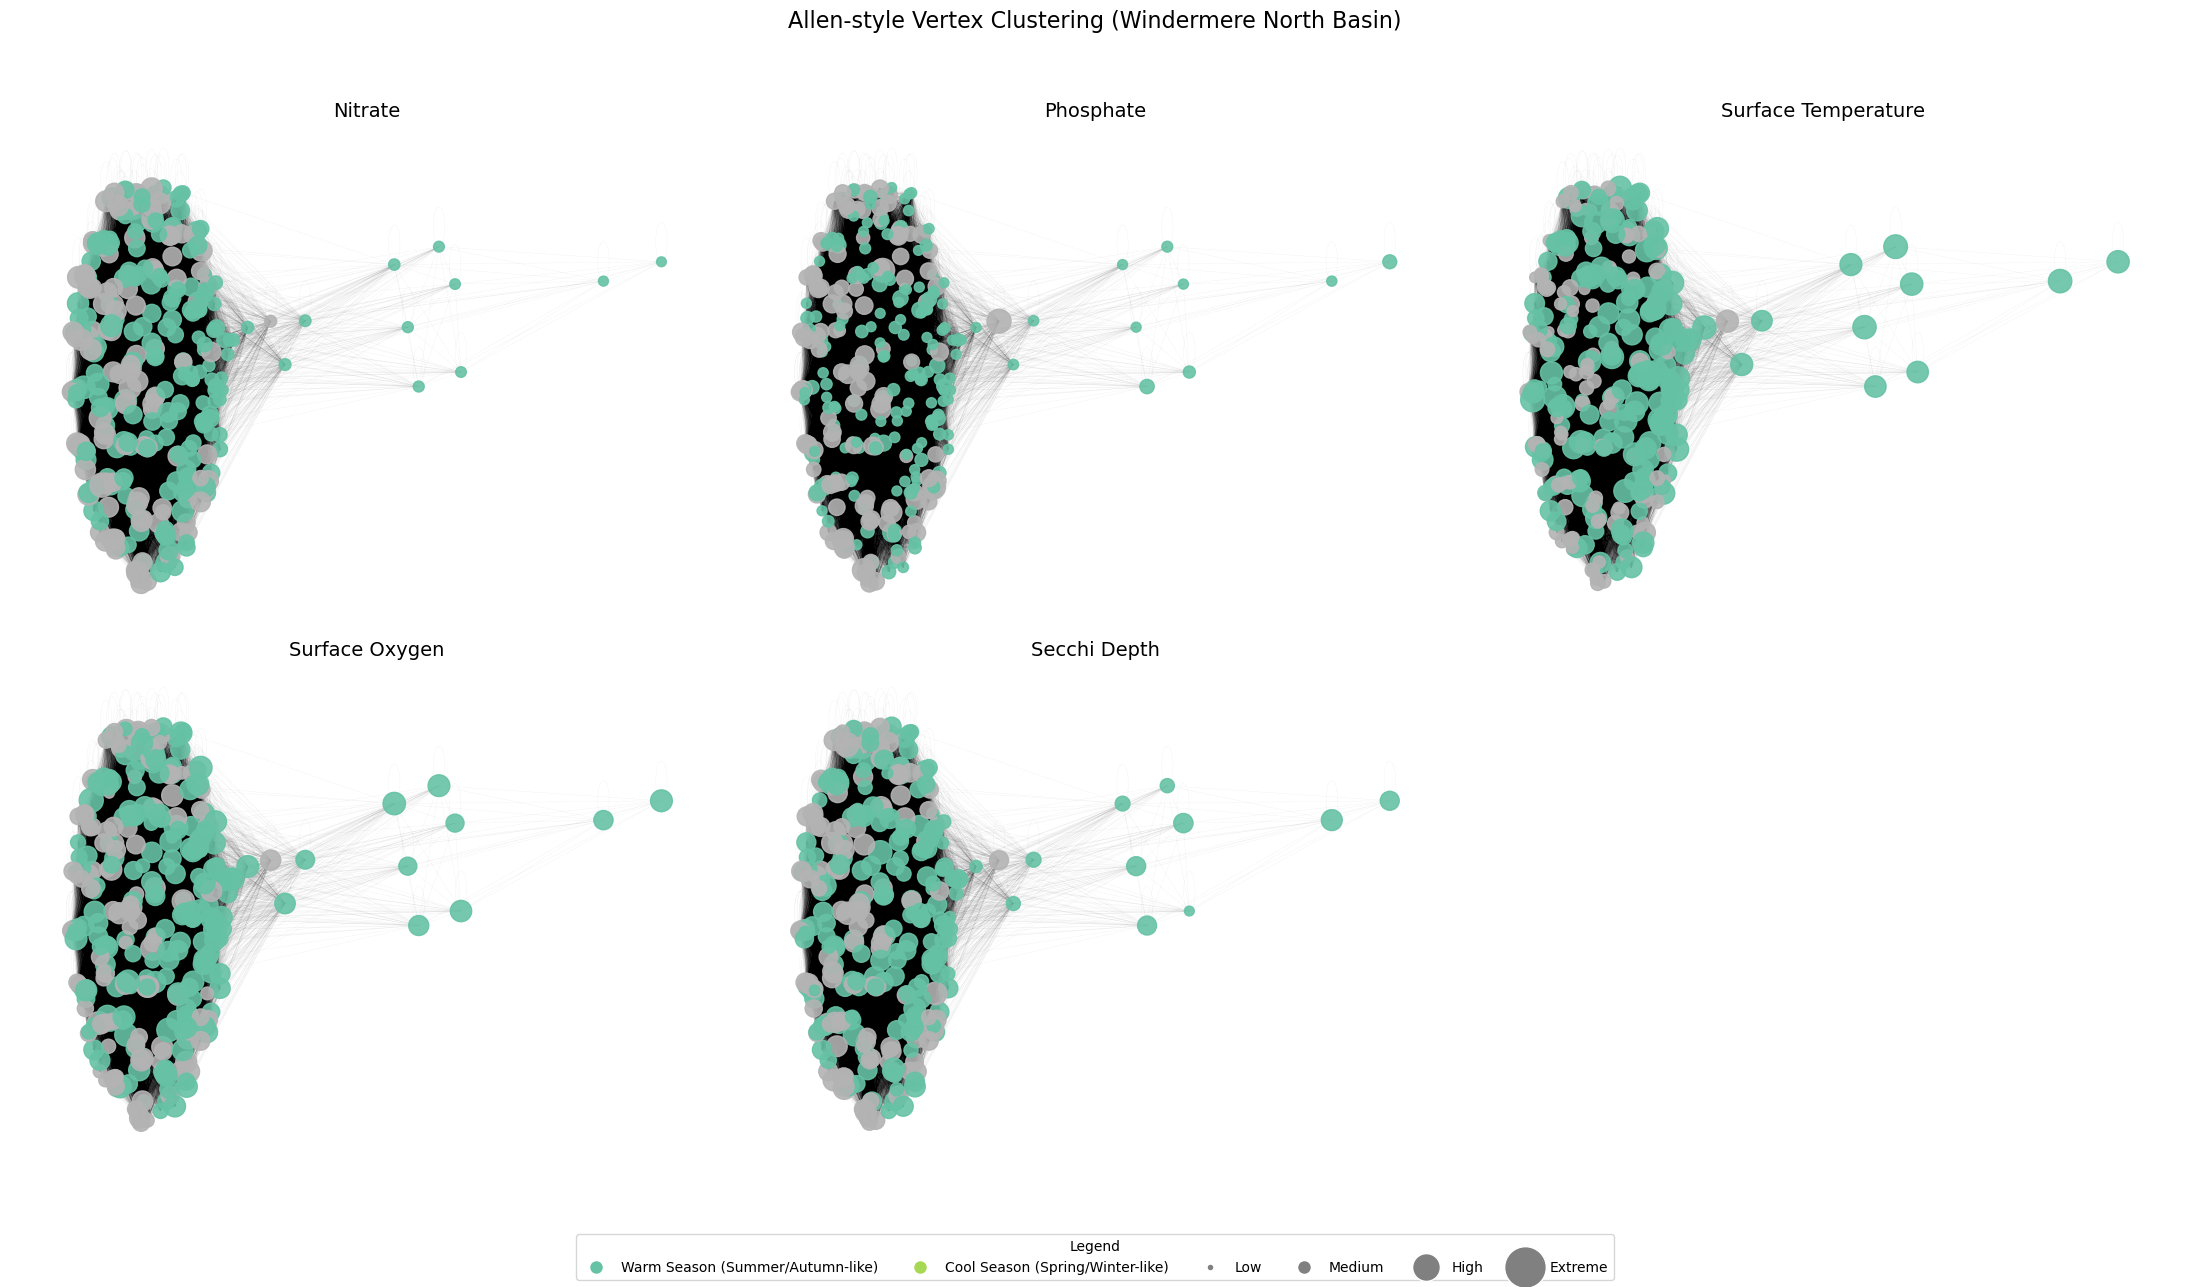

In [82]:
# Variables to visualize
variables = ["Nitrate", "Phosphate", "Surface Temperature", "Surface Oxygen", "Secchi Depth"]
n_panels = len(variables)

# Make sure Label is the index and matches G nodes
node_labels = list(G.nodes())

# Create multi-panel layout
fig, axes = plt.subplots(2, 3, figsize=(22, 13))
axes = axes.flatten()

# Loop through variables to plot
for i, var in enumerate(variables):
    ax = axes[i]

    # Size = scaled value of the variable
    node_sizes = monthly_all.loc[node_labels, var].fillna(0)
    scaled_sizes = (node_sizes - node_sizes.min()) / (node_sizes.max() - node_sizes.min())
    scaled_sizes = scaled_sizes * 250 + 50

    # Color = Cluster label
    cluster_codes = monthly_all.loc[node_labels, "Cluster_Label"].astype("category").cat.codes

    # Draw edges + nodes
    nx.draw_networkx_edges(G, pos, alpha=0.05, edge_color="black", width=0.3, ax=ax)
    nx.draw_networkx_nodes(G, pos,
                           node_color=cluster_codes,
                           cmap=plt.cm.Set2,
                           node_size=scaled_sizes,
                           alpha=0.9,
                           ax=ax)
    ax.set_title(f"{var}", fontsize=14)
    ax.axis("off")

# Remove any unused subplots
if n_panels < len(axes):
    fig.delaxes(axes[-1])

# Cluster label legend
unique_labels = monthly_all["Cluster_Label"].unique()
cluster_legend = [
    Line2D([0], [0], marker='o', color='w', label=lbl,
           markerfacecolor=plt.cm.Set2(i / len(unique_labels)), markersize=10)
    for i, lbl in enumerate(unique_labels)
]

# Size legend
size_legend = [
    Line2D([0], [0], marker='o', color='w', label='Low', markerfacecolor='gray', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Medium', markerfacecolor='gray', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='High', markerfacecolor='gray', markersize=20),
    Line2D([0], [0], marker='o', color='w', label='Extreme', markerfacecolor='gray', markersize=30),
]

# Combine legends
fig.legend(handles=cluster_legend + size_legend,
           loc='lower center', ncol=6, frameon=True, fontsize=10, title='Legend')

# Add final layout polish
plt.suptitle("Vertex Clustering (Windermere North Basin)", fontsize=16)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()


In [84]:
# === Cluster Summary Table for Windermere North Basin ===

# Select key environmental variables to summarize
summary_vars = ['Nitrate', 'Ammonium', 'Phosphate',
                'Surface Oxygen', 'Surface Temperature', 'Secchi Depth']

# Group by interpreted seasonal clusters
summary = monthly_all.groupby("Cluster_Label")[summary_vars].mean().round(2)

# Add column with number of months in each cluster
summary["Months"] = monthly_all["Cluster_Label"].value_counts().reindex(summary.index)

# Reset index for display
summary = summary.reset_index()

# Display
import pandas as pd
import IPython.display as display
display.display(summary)


,Cluster_Label,Nitrate,Ammonium,Phosphate,Surface Oxygen,Surface Temperature,Secchi Depth,Months
0,Cool Season (Spring/Winter-like),348.58,10.66,1.48,98.70,13.50,4.58,208
1,Warm Season (Summer/Autumn-like),509.36,6.31,6.55,94.71,6.27,5.00,128


Key Differences vs Esthwaite / South Basin
Aspect	Esthwaite / South Basin	Windermere North Basin
Phytoplankton Data	✅ Available and used (Cyano, Diatoms, etc.)	❌ Not available (zooplankton only present)
Feature Importance	✅ Via Random Forest	❌ Skipped (no target variable)
Number of Clusters (k)	5–7 clusters	2 clusters
Visual Style	Allen-style panels with edges and legend	✅ Matched style successfully
Seasonal Labels	Multi-season bloom-based	Simple warm/cool split



You're all set with Windermere North. If needed, we can:

Attempt to incorporate zooplankton instead of phytoplankton (alternative ecological interpretation)